In [0]:
!pip install soundfile
!pip install python_speech_features
!pip install nbimporter

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5889 sha256=bc4d11f2df8b6bdc86d4180b710fec8164b6506c23a251fcf894c62e252d3a3b
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features
  Created wheel for nbimporter: filename=nbimporter-0.3.1-cp36-none-any.whl size=3792 sha256=93fa183624f240bcc1da90c57d4924096de6d5b73a89fe9cf92120e7e7edb47e
  Stored in directory: /root/.cache/pip/wheels/44/7d/40/f48fe3f0995a282d582ca73a6807b9bb23c8cc3f1525e62429
Successfully built nbimporter


In [0]:
#checking hardware
import tensorflow as tf 
print (tf.__version__)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

1.15.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17006815461363810901, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1516449675334690234
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16205187850632895030
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5267754427982348993
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/Colab Notebooks/dihard/audio_processing.ipynb" .
#dir for preprocessing
!mkdir processing

In [0]:
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization,  Lambda , TimeDistributed, concatenate, Flatten, Conv1D,MaxPooling1D, Dropout, Reshape
from tensorflow.keras.models import Sequential, Model
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os
from tensorflow.keras import backend as K
import IPython.display as ipd

import nbimporter
import audio_processing as processing

Importing Jupyter notebook from audio_processing.ipynb


In [0]:
wav_input_shape=8000*5#(10, 8000)
#mfcc_input_shape=(499, 26,1)

if os.name=="nt":
  data_source="data\\"
  data_processing="C:\\Users\\Dima\\rrrr\\dihart_processing\\"
else:
  data_source='/content/drive/My Drive/Colab Notebooks/dihard/data/'
  data_processing="./processing/"

batch_size=64

In [0]:
%%time
#preprocess files. takes 15 mins in Google Colab
processing.preprocess_files_siam(data_source,data_processing,input_shape=wav_input_shape,save_mfcc=True,num_mfcc_feratures=26)

In [0]:
processing.train_test_split(data_processing,0.15)

DONE.
Total files: 329 . Test files: 49


In [0]:
#Siamese Network with Cosine similarity
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, BatchNormalization, SpatialDropout2D, Activation, Dot

class Siamese_Encoder_mfcc_cosine(object):
    def __init__(self,mfcc_input_shape, verbose=True):
        self.mfcc_input_shape=mfcc_input_shape
        self.verbose=verbose

        self.SM = None  # Siamese model
        self.E=   None   # Encoder graph
        self.S=   None   # siamese Graph
        
        self.E=self.encoder()   
        self.S=self.siamese()  
        
    def encoder(self):
        if self.E:
            return self.E
        else:        
            self.E=Sequential()
            self.E.add(Convolution2D(input_shape=self.mfcc_input_shape,
                                     filters=16,kernel_size=(3,3),activation='relu'))
            self.E.add(Convolution2D(16,kernel_size=(3,3),activation=None))
            self.E.add(MaxPooling2D(pool_size=(2,2)))
            self.E.add(SpatialDropout2D(rate=0.25))
            self.E.add(BatchNormalization())
            self.E.add(Activation('relu'))

            self.E.add(Convolution2D(32,kernel_size=(3,3),activation='relu'))
            self.E.add(Convolution2D(32,kernel_size=(3,3),activation=None))
            self.E.add(MaxPooling2D(pool_size=(2,2)))
            self.E.add(SpatialDropout2D(rate=0.25))
            self.E.add(BatchNormalization())
            self.E.add(Activation('relu'))

            self.E.add(Flatten())
            self.E.add(Dense(1024,activation='relu'))
            self.E.add(Dropout(0.25))
            self.E.add(Dense(512,activation='relu'))

            if self.verbose: 
                print("=+"*5+"encoder"+'=+'*5)
                self.E.summary()
            return self.E
    

    def siamese(self):

      input_a_mfcc =  Input(shape=self.mfcc_input_shape)
      input_b_mfcc = Input(shape=self.mfcc_input_shape)

      encoded_a=self.E([input_a_mfcc])
      encoded_b=self.E([input_b_mfcc])
      distance=Dot(axes=-1,normalize=True)([encoded_a,encoded_b]) 

      siam_model=Model(inputs=[input_a_mfcc,input_b_mfcc],outputs=[distance])

      if self.verbose: 
            print("\n"+"=+"*5+"siam"+'=+'*5+"\n")
            siam_model.summary()

      return siam_model
    
    
    def siamese_model(self):
  
      if self.SM: return self.SM
      else:
        print("...")
        self.SM=self.S
        self.SM.compile(optimizer='adam',
                            #loss='mean_squared_error',
                            loss='binary_crossentropy',
                            metrics=['binary_crossentropy','accuracy'])

      return self.SM

In [0]:
#Siamese Model with dense binary classifier

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, BatchNormalization, SpatialDropout2D, Activation, Dot

class Siamese_Encoder_mfcc_dense(object):
    def __init__(self,mfcc_input_shape, verbose=True):
        #self.wav_input_shape=wav_input_shape
        self.mfcc_input_shape=mfcc_input_shape
        self.verbose=verbose

        self.SM = None  # Siamese model
        self.E=   None   # Encoder
        self.S=   None
        
        self.E=self.encoder()   
        self.S=self.siamese()  
        
        
    def encoder(self):
        if self.E:
            return self.E
        else:        
            self.E=Sequential()
            self.E.add(Convolution2D(input_shape=self.mfcc_input_shape,
                                     filters=16,kernel_size=(3,3),activation='relu'))
            self.E.add(Convolution2D(16,kernel_size=(3,3),activation=None))
            self.E.add(MaxPooling2D(pool_size=(2,2)))
            self.E.add(SpatialDropout2D(rate=0.25))
            self.E.add(BatchNormalization())
            self.E.add(Activation('relu'))

            self.E.add(Convolution2D(32,kernel_size=(3,3),activation='relu'))
            self.E.add(Convolution2D(32,kernel_size=(3,3),activation=None))
            self.E.add(MaxPooling2D(pool_size=(2,2)))
            self.E.add(SpatialDropout2D(rate=0.25))
            self.E.add(BatchNormalization())
            self.E.add(Activation('relu'))

            self.E.add(Flatten())
            self.E.add(Dense(1024,activation='relu'))
            self.E.add(Dropout(0.25))
            self.E.add(Dense(512,activation='relu'))

            if self.verbose: 
                print("=+"*5+"encoder"+'=+'*5)
                self.E.summary()
            return self.E
    
    def siamese(self):
      input_a_mfcc =  Input(shape=self.mfcc_input_shape)
      input_b_mfcc = Input(shape=self.mfcc_input_shape)

      encoded_a=self.E([input_a_mfcc])
      encoded_b=self.E([input_b_mfcc])

      x=concatenate([encoded_a,encoded_b])

      dense1=Dense(1024,activation='relu')(x)
      output=Dense(1,activation='sigmoid',name="bin_classifier")(dense1)     

      siam_model=Model(inputs=[input_a_mfcc,input_b_mfcc],outputs=[output])

      if self.verbose: 
            print("\n"+"=+"*5+"siam"+'=+'*5+"\n")
            siam_model.summary()

      return siam_model
    
    
    def siamese_model(self):

      if self.SM: return self.SM
      else:
        print("...")
        self.SM=self.S
        self.SM.compile(optimizer='adam',
                            #loss='mean_squared_error',
                            loss='binary_crossentropy',
                            metrics=['binary_crossentropy','accuracy'])
   
      return self.SM

In [0]:
def gen_wrapper(generator):
  '''
  we need it to flip zeros and ones, as cosine similarity returns 1 for similar vectors
  '''
  while 1:
    x,y=generator.__next__()
    yield x,(y==0).astype(int)

In [0]:
def eval_model(model, generator,epochs=100):
  '''
  evaluates the model using the generator
  '''
  evaluations=[]
  for i in range(epochs):
    x,y=generator.__next__()
    evaluations.append(model.evaluate(x,y))
  evaluations=np.array(evaluations)

  return evaluations.mean(axis=0),evaluations

In [0]:
#Running the experiment
%time
#list of parameters. Shapes of wav files and mfcc files. 
full_size=([2000,4000,8000,16000,24000,32000,40000],
              [(25,26,1),
               (50,26,1),
               (100,26,1),
               (200,26,1),
               (299,26,1),
               (399,26,1),
               (499, 26,1)])

small=([2000,4000,8000],
              [(25,26,1),
               (50,26,1),
               (100,26,1)])

test=[[32000,40000],
      [(399,26,1),(499, 26,1)]]

epochs=40
test_epochs=100
steps_per_epoch=250

experiment=[]

for wav_input_shape, mfcc_input_shape in zip(full_size[0],full_size[1]) :
  print ('\n',wav_input_shape,mfcc_input_shape)

  #creating the models
  siam_dense=Siamese_Encoder_mfcc_dense(mfcc_input_shape,verbose=0)
  siam_cosine=Siamese_Encoder_mfcc_cosine(mfcc_input_shape,verbose=0)
  dense_model=siam_dense.siamese_model()
  cosine_model=siam_cosine.siamese_model()
  
  # creating the generators
  dense_generator_train=processing.data_generator_siam_precomputed(data_processing,batch_size,
                                                          input_shape=wav_input_shape,mfcc_len=mfcc_input_shape[0],
                                                          num_files=10,verbose=0,num_feratures=26,mfcc_only=True)
  dense_generator_test=processing.data_generator_siam_precomputed(data_processing+"test//",batch_size,
                                                          input_shape=wav_input_shape,mfcc_len=mfcc_input_shape[0],
                                                          num_files=10,verbose=0,num_feratures=26,mfcc_only=True)
  gen1_train=processing.data_generator_siam_precomputed(data_processing,batch_size,
                                                          input_shape=wav_input_shape,mfcc_len=mfcc_input_shape[0],
                                                          num_files=10,verbose=0,num_feratures=26,mfcc_only=True)
  cosine_generator_train=gen_wrapper(gen1_train)
  gen1_test=processing.data_generator_siam_precomputed(data_processing+"test//",batch_size,
                                                          input_shape=wav_input_shape,mfcc_len=mfcc_input_shape[0],
                                                          num_files=10,verbose=0,num_feratures=26,mfcc_only=True)
  cosine_generator_test=gen_wrapper(gen1_test)

  # packing all of them into the lists
  models=[dense_model,cosine_model]
  generators_train=[dense_generator_train,cosine_generator_train]
  generators_test=[dense_generator_test,cosine_generator_test]

  #train, evaluate and save the results to list
  for model,generator_train,generator_test,caption in zip (models,generators_train,generators_test,("dense",'cosine')):
    print('\n',caption)
    history=model.fit_generator(generator_train,epochs=epochs,steps_per_epoch=steps_per_epoch,verbose=1,use_multiprocessing=True,workers=4) 
    print("Evaluation")
    e,evaluations= eval_model(model,generator_test,epochs=test_epochs)
    log=[wav_input_shape,mfcc_input_shape,caption,history,e,evaluations]
    experiment.append(log)
    print("=+"*20)

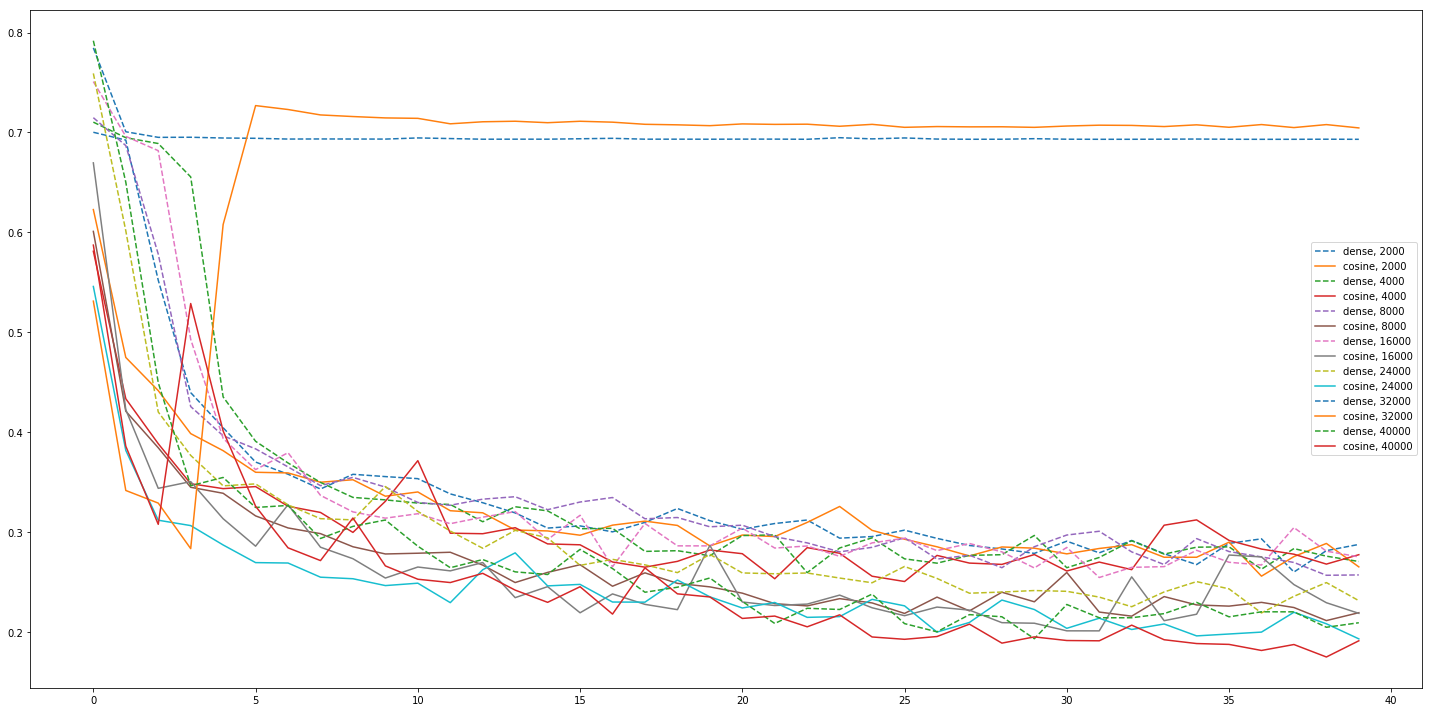

In [0]:
#visualizing the training loss
legend=[]
plt.figure(figsize=(20,10))
for e in experiment:
  loss=e[3].history['loss']
  if e[2]=='dense':
    plt.plot(loss,'--')
  else:
    plt.plot(loss)
  legend.append(e[2]+", "+str(e[0]))
plt.legend(legend)
#plt.show()
plt.tight_layout()
plt.savefig('training_history.png')

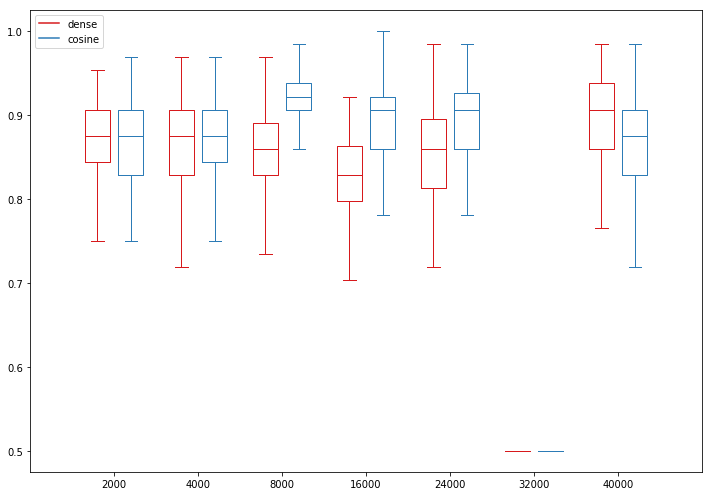

In [0]:
#visualizing the accuracy of each model
scores_dense,scores_cosine=[],[]
for e in experiment:
  scores=e[5][:,2]
  if e[2]=='dense':
    scores_dense.append(scores)
  else:
    scores_cosine.append(scores)

data_a = scores_dense
data_b = scores_cosine

ticks =full_size[0]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(10,7))

bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='dense')
plt.plot([], c='#2C7BB6', label='cosine')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
#plt.ylim(0.25, 1)
plt.tight_layout()
plt.savefig('boxcompare.png')

In [0]:
!cp *.png "/content/drive/My Drive/Colab Notebooks/dihard/"

cp: target '/content/drive/My Drive/Colab Notebooks/dihard/' is not a directory


In [0]:
#One more experiment for visualization

wav_input_shape=4000
mfcc_input_shape=(50,26,1)
net=Siamese_Encoder_mfcc_dense(mfcc_input_shape,verbose=1)

model=net.siamese_model()


g1=processing.data_generator_siam_precomputed(data_processing,batch_size,
                                                        input_shape=wav_input_shape,mfcc_len=mfcc_input_shape[0],
                                                        num_files=10,verbose=0,num_feratures=26,mfcc_only=True)
generator=gen_wrapper(g1)

=+=+=+=+=+encoder=+=+=+=+=+
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 24, 16)        160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 22, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 11, 16)        0         
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 23, 11, 16)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 23, 11, 16)        64        
_________________________________________________________________
activation_4 (Activation)    (None, 23, 11, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)        

In [0]:
history=model.fit_generator(generator,epochs=20,steps_per_epoch=250,verbose=1,use_multiprocessing=True,workers=10)

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
250/250 [==============================] - 24s 94ms/step - loss: 0.5777 - binary_crossentropy: 0.5777 - acc: 0.6731
Epoch 2/20
250/250 [==============================] - 19s 74ms/step - loss: 0.3952 - binary_crossentropy: 0.3952 - acc: 0.8166
Epoch 3/20
250/250 [==============================] - 18s 71ms/step - loss: 0.3759 - binary_crossentropy: 0.3759 - acc: 0.8312
Epoch 4/20
250/250 [==============================] - 17s 69ms/step - loss: 0.3504 - binary_crossentropy: 0.3504 - acc: 0.8449
Epoch 5/20
250/250 [==============================] - 18s 71ms/step - loss: 0.3340 - binary_crossentropy: 0.3340 - acc: 0.8583
Epoch 6/20
250/250 [==============================] - 18s 74ms/step - loss: 0.3175 - binary_crossentropy: 0.3175 - acc: 0.8608
Epoch 7/20
250/250 [==============================] - 18s 74ms/step - loss: 0.3150 - binary_crossentropy: 0.3150 - acc: 0.8646
Epoch 8/20
250/25

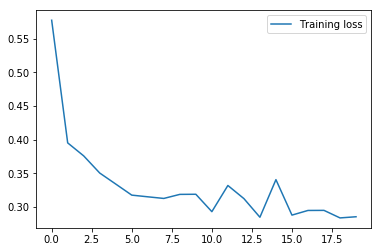

In [0]:
loss = history.history['loss']
#val_loss= history.history['val_loss']
plt.plot(loss)
#plt.plot(val_loss)
plt.legend(['Training loss'])#,'Validation loss'])
plt.show()

In [0]:
#test generator
data_generator=processing.data_generator_siam_precomputed(data_processing+'test/',batch_size=100,
                                                          input_shape=wav_input_shape,mfcc_len=mfcc_input_shape[0],
                                                          num_files=10,verbose=0,num_feratures=26,mfcc_only=False)
my_gen=gen_wrapper(data_generator)

x,y=my_gen.__next__()

In [0]:
evaluations=model.evaluate([x[1],x[3]],y)
evaluations

100/100 [==============================] - 0s 301us/sample - loss: 0.2614 - binary_crossentropy: 0.2614 - acc: 0.9000


[0.2613697499036789, 0.26136974, 0.9]

In [0]:
#Checking if the errors make sense
prediction=model.predict([x[1],x[3]])
pr=np.round(prediction)
(np.round(prediction[:,0],decimals=2))

array([0.85, 0.  , 0.88, 0.73, 0.4 , 0.  , 0.97, 0.03, 0.99, 0.  , 0.95,
       0.44, 0.91, 0.96, 0.98, 0.03, 1.  , 0.01, 0.98, 0.  , 0.94, 0.  ,
       0.97, 0.  , 0.88, 0.  , 0.99, 0.  , 0.83, 0.  , 0.98, 0.  , 0.92,
       0.03, 0.02, 0.  , 0.88, 0.29, 0.98, 0.  , 0.99, 0.1 , 0.76, 0.  ,
       0.81, 0.02, 0.95, 0.5 , 0.92, 0.  , 0.67, 0.11, 0.98, 0.73, 0.86,
       0.  , 0.86, 0.  , 0.99, 0.  , 0.89, 0.  , 0.95, 0.  , 0.98, 0.37,
       0.6 , 0.  , 0.06, 0.02, 0.47, 0.89, 0.95, 0.  , 0.76, 0.  , 0.98,
       0.  , 0.97, 0.  , 0.97, 0.05, 0.96, 0.  , 0.99, 0.94, 0.97, 0.  ,
       0.66, 0.  , 0.94, 0.07, 0.94, 0.  , 0.96, 0.  , 0.96, 0.  , 1.  ,
       0.01], dtype=float32)

In [0]:
print("errors:")
i=0
for p,gt in zip(pr,y):
  if p!=gt: z="ERROR!!"
  else: z=""
  if z!="": print(i,gt,p,prediction[i],z)
  i+=1
  # unmber in batch|Ground truth label|prediction|score|

errors:
3 0 [1.] [0.7336828] ERROR!!
4 1 [0.] [0.4022803] ERROR!!
13 0 [1.] [0.95572054] ERROR!!
34 1 [0.] [0.01886959] ERROR!!
47 0 [1.] [0.50406736] ERROR!!
53 0 [1.] [0.7287737] ERROR!!
68 1 [0.] [0.05586703] ERROR!!
70 1 [0.] [0.4695336] ERROR!!
71 0 [1.] [0.8900749] ERROR!!
85 0 [1.] [0.93664515] ERROR!!


In [0]:
i=71
#print(inf[i])
print (y[i],pr[i],prediction[i])
ipd.Audio(x[0][i],rate=8000)

0 [1.] [0.8900749]


In [0]:
ipd.Audio(x[2][i],rate=8000)

In [0]:
speech_f=os.listdir(data_processing)
speech_files=np.array([f for f in speech_f if ".wav" in f])
print(len(speech_files))
f1=speech_files[142]
f2=speech_files[211]
f3=speech_files[99]
sr=8000

myfiles=[f1,f3]

280


In [0]:
raw_file1=np.load(data_processing+f1)
ipd.Audio(raw_file1,rate=sr)

In [0]:
raw_file2=np.load(data_processing+f2)
ipd.Audio(raw_file2,rate=sr)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
raw_file3=np.load(data_processing+f3)
ipd.Audio(raw_file3,rate=sr)

In [0]:
#Visualization with PCA and T-SNE

In [0]:
e=[]
labels=[]
j=0
for f in myfiles:
  print(j)
  raw_file=np.load(data_processing+f)
  x=[]
  for i in range(100):
    x.append(raw_file[i*(wav_input_shape+50):(i+1)*(wav_input_shape+50)])
  x=np.array(x)
  print(x.shape)

  mfccs=[]
  for w in x:
      m=mfcc(w,samplerate=sr,numcep=26)
      # m=m.ravel()
      mfccs.append(m)
  x=np.array(mfccs)
  x=x.reshape((*x.shape,1)).astype('float32')
  print(x.shape)
  e1=net.E.predict(x)
  e.append(e1)
  labels.append(np.ones(len(x)).astype(int)*j)
  j+=1
  
e=np.vstack(e)
labels=np.hstack(labels)

0
(100, 4050)
(100, 50, 26, 1)
1
(100, 4050)
(100, 50, 26, 1)


In [0]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [0]:
from python_speech_features import mfcc
mfccs=[]
for w in x:
    m=mfcc(w,samplerate=sr,numcep=26)
    # m=m.ravel()
    mfccs.append(m)
x=np.array(mfccs)
x=x.reshape((*x.shape,1)).astype('float32')
print(x.shape)

(100, 50, 26, 1)


In [0]:
e1=net.E.predict(x)

In [0]:
x=[]
for i in range(100):
  x.append(raw_file2[i*(wav_input_shape+50):(i+1)*(wav_input_shape+50)])
x=np.array(x)
print(x.shape)
from python_speech_features import mfcc
mfccs=[]
for w in x:
    m=mfcc(w,samplerate=sr,numcep=26)
    # m=m.ravel()
    mfccs.append(m)
x=np.array(mfccs)
x=x.reshape((*x.shape,1)).astype('float32')
print(x.shape)

(100, 4050)
(100, 50, 26, 1)


In [0]:
e2=net.E.predict(x)

In [0]:
print(e1.shape,e2.shape)
e=np.vstack((e1,e2))
print(e.shape)

(100, 512) (100, 512)
(200, 512)


In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
dimreducer = TSNE(n_components=2)

reduced_original = dimreducer.fit_transform(e)

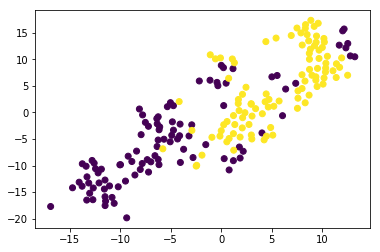

In [0]:
#labels=np.hstack((np.zeros(len(x)),np.ones(len(x)))).astype(int)
n=np.array(range(len(reduced_original)))
fig, ax = plt.subplots()
ax.scatter(reduced_original[:,0],reduced_original[:,1],c=labels)
#
#for i, txt in enumerate(n):
#    ax.annotate(txt, (reduced_original[:,0],reduced_original[:,1]))

#plt.scatter()